## Ocean Stats

In [1]:
# The usual preamble
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings, yaml, os
from datetime import datetime
import getpass
import xarray as xr
warnings.filterwarnings("ignore")
from mom6_tools.DiagsCase import DiagsCase

In [2]:
# Make the graphs a bit prettier, and bigger
plt.style.use('ggplot')
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams.update({'font.size': 18})

In [3]:
# Read in the yaml file
diag_config_yml_path = "diag_config.yml"
diag_config_yml = yaml.load(open(diag_config_yml_path,'r'), Loader=yaml.Loader)
dcase = DiagsCase(diag_config_yml['Case'])

In [4]:
CASEROOT = dcase.get_value('CASEROOT')

In [5]:
DOUT_S = dcase.get_value('DOUT_S')

In [6]:
dcase.get_value('DOUT_S_ROOT')

'/glade/scratch/gmarques/archive/gmom.e23.GJRAv3.TL319_t061_zstar_N75.nuopc.ctrl_cice5.001'

In [7]:
rundir = dcase.get_value('RUNDIR')

In [8]:
rundir

'/glade/scratch/gmarques/gmom.e23.GJRAv3.TL319_t061_zstar_N75.nuopc.ctrl_cice5.001/run'

In [9]:
header = ["Step", "Day","Truncs", "Energy/Mass",      
          "Maximum CFL", "Mean Sea Level", 
          "Total Mass", "Mean Salin", "Mean Temp",
         "Frac Mass Err", "Salin Err", "Temp Err"]
df = pd.read_csv(rundir+'/ocean.stats',  delimiter=',', 
                 usecols=(0,1,2,3,4,5,6,7,8,9,10,11),skiprows=(0,1),
                 names=header)#, skiprows=1) #, 
                # index_col=0,
                # dtype='unicode',
                # encoding = 'unicode_escape')

In [10]:
df.head()

,Step,Day,Truncs,Energy/Mass,Maximum CFL,Mean Sea Level,Total Mass,Mean Salin,Mean Temp,Frac Mass Err,Salin Err,Temp Err
0,0,0.0,0,En 2.4571649248052563E-23,CFL 0.00000,SL -1.3599E-10,M 1.38614E+21,S 34.7202,T 3.5781,Me 0.00E+00,Se 0.00E+00,Te 0.00E+00
1,23,1.0,0,En 9.8229291753917361E-04,CFL 0.05889,SL -1.3670E-10,M 1.38614E+21,S 34.7202,T 3.5781,Me 8.12E-19,Se 1.78E-16,Te -7.67E-18
2,47,2.0,0,En 1.0482233201342180E-03,CFL 0.05207,SL -1.3812E-10,M 1.38614E+21,S 34.7202,T 3.5780,Me 4.31E-20,Se -4.04E-18,Te -2.87E-18
3,71,3.0,0,En 1.1105543550252754E-03,CFL 0.05763,SL -1.3741E-10,M 1.38614E+21,S 34.7202,T 3.5780,Me 2.58E-19,Se -1.45E-17,Te -3.99E-18
4,95,4.0,0,En 1.0893979622969257E-03,CFL 0.06174,SL -1.3883E-10,M 1.38614E+21,S 34.7202,T 3.5779,Me -9.09E-20,Se -9.35E-17,Te -4.40E-18


In [11]:
# remove characters from each coloumn
for var in header[3::]:
    print(var)
    df[var] = df[var].str.replace(r'[^0-9.]+', '').astype(float)

df.head()

Energy/Mass
Maximum CFL
Mean Sea Level
Total Mass
Mean Salin
Mean Temp
Frac Mass Err
Salin Err
Temp Err


,Step,Day,Truncs,Energy/Mass,Maximum CFL,Mean Sea Level,Total Mass,Mean Salin,Mean Temp,Frac Mass Err,Salin Err,Temp Err
0,0,0.0,0,2.457165,0.00000,1.35991,1.386142,34.7202,3.5781,0.0000,0.0000,0.0000
1,23,1.0,0,9.822929,0.05889,1.36701,1.386142,34.7202,3.5781,8.1219,1.7816,7.6718
2,47,2.0,0,1.048223,0.05207,1.38121,1.386142,34.7202,3.5780,4.3120,4.0418,2.8718
3,71,3.0,0,1.110554,0.05763,1.37411,1.386142,34.7202,3.5780,2.5819,1.4517,3.9918
4,95,4.0,0,1.089398,0.06174,1.38831,1.386142,34.7202,3.5779,9.0920,9.3517,4.4018


In [12]:
df.head()

,Step,Day,Truncs,Energy/Mass,Maximum CFL,Mean Sea Level,Total Mass,Mean Salin,Mean Temp,Frac Mass Err,Salin Err,Temp Err
0,0,0.0,0,2.457165,0.00000,1.35991,1.386142,34.7202,3.5781,0.0000,0.0000,0.0000
1,23,1.0,0,9.822929,0.05889,1.36701,1.386142,34.7202,3.5781,8.1219,1.7816,7.6718
2,47,2.0,0,1.048223,0.05207,1.38121,1.386142,34.7202,3.5780,4.3120,4.0418,2.8718
3,71,3.0,0,1.110554,0.05763,1.37411,1.386142,34.7202,3.5780,2.5819,1.4517,3.9918
4,95,4.0,0,1.089398,0.06174,1.38831,1.386142,34.7202,3.5779,9.0920,9.3517,4.4018


In [13]:
# rename columns
new_header = ["Step", "Day","Truncs", "EnergyMass",      
          "MaximumCFL", "MeanSeaLevel", 
          "TotalMass", "MeanSalin", "MeanTemp",
         "FracMassErr", "SalinErr", "TempErr"]
for old, new in zip(header, new_header):
  df = df.rename(columns={old:new})

In [14]:
df.head()

,Step,Day,Truncs,EnergyMass,MaximumCFL,MeanSeaLevel,TotalMass,MeanSalin,MeanTemp,FracMassErr,SalinErr,TempErr
0,0,0.0,0,2.457165,0.00000,1.35991,1.386142,34.7202,3.5781,0.0000,0.0000,0.0000
1,23,1.0,0,9.822929,0.05889,1.36701,1.386142,34.7202,3.5781,8.1219,1.7816,7.6718
2,47,2.0,0,1.048223,0.05207,1.38121,1.386142,34.7202,3.5780,4.3120,4.0418,2.8718
3,71,3.0,0,1.110554,0.05763,1.37411,1.386142,34.7202,3.5780,2.5819,1.4517,3.9918
4,95,4.0,0,1.089398,0.06174,1.38831,1.386142,34.7202,3.5779,9.0920,9.3517,4.4018


In [15]:
units = ['nondim', 'days', 'nondim', 'm2 s-2',' nondim',
         'm', 'kg', 'PSU' , 'degC', 'nondim', 'PSU', 'degC']

data_vars = {}
for var, unit in zip(new_header, units):
  data_vars.update({var:(('time'), df[var], {"units" : unit})})

In [16]:
ds = xr.open_dataset(rundir+"/ocean.stats.nc").rename({"Time" : "time"})

In [17]:
variables = [
    'En',
    'Ntrunc',
    'Mass',
    'Mass_chg',
    'Mass_anom',
    'max_CFL_trans',
    'max_CFL_lin',
    'Salt',
    'Salt_chg',
    'Salt_anom',    
    'Heat',
    'Heat_chg',
    'Heat_anom',
    'age'
    
]

for v in variables:
  data_vars.update({v:(('time'), ds[v].values, {"units" : ds[v].units})})

In [18]:
data_vars.update({"APE":(("time", "Interface"), 
                         ds.APE.values, {"units" : ds.APE.units})})
data_vars.update({"H0":(("time", "Interface"), 
                        ds.H0.values, {"units" : ds.H0.units})})
data_vars.update({"KE":(("time", "Layer"), 
                        ds.KE.values, {"units" : ds.KE.units})})
data_vars.update({"Mass_lay":(("time", "Layer"), 
                              ds.Mass_lay.values, {"units" : ds.Mass_lay.units})})

In [19]:
#data_vars
time_units = "days since {}".format(dcase.get_value('RUN_STARTDATE')) 
attrs = {"units": time_units, "calendar" : "noleap"}
coords={"time": ("time", df["Day"], attrs),
        "Layer" : ("Layer", ds.Layer.values),
        "Interface" : ("Interface", ds.Interface.values)}

In [20]:
# create dataset to store results
msg = " can be found at https://github.com/NCAR/mom6-tools"
attrs = {"description": "ocean stats time-series derived from ocean.stats",
         "casename" : dcase.casename,
         "caseroot" : CASEROOT,
         "author" : getpass.getuser(),
         "date" : datetime.now().isoformat(),
         "created_using" : "file.txt"}
stats = xr.decode_cf(xr.Dataset(data_vars=data_vars,
                   coords=coords,
                 attrs = attrs,
                ))

In [21]:
stats.to_netcdf('ncfiles/{}_ocean.stats.nc'.format(dcase.casename))

In [22]:
stats_monthly = stats.resample(time="1M", 
                               closed='left',
                               keep_attrs='True').mean('time', keep_attrs=True)

### Truncations

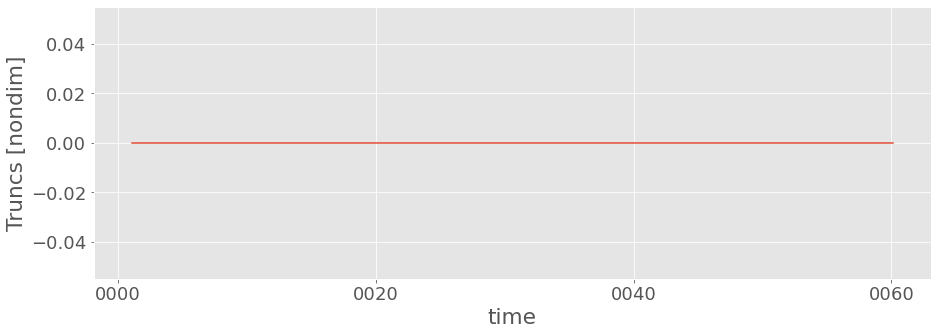

In [23]:
stats_monthly.Truncs.plot();

### Maximum finite-volume CFL

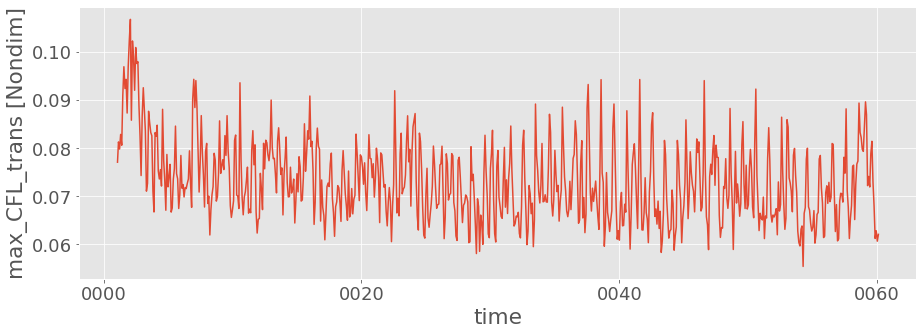

In [24]:
stats_monthly.max_CFL_trans.plot();

### Maximum finite-difference CFL

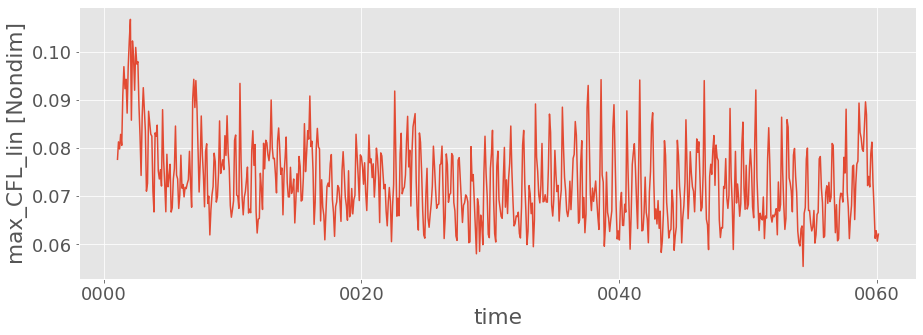

In [25]:
stats_monthly.max_CFL_lin.plot();

### Maximum CFL

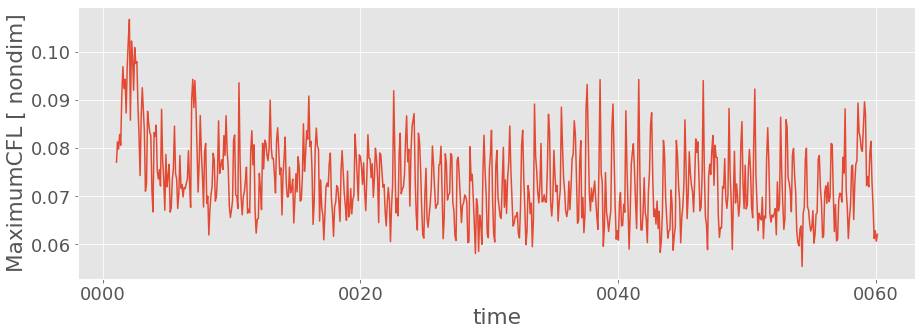

In [26]:
stats_monthly.MaximumCFL.plot();

### Energy/Mass

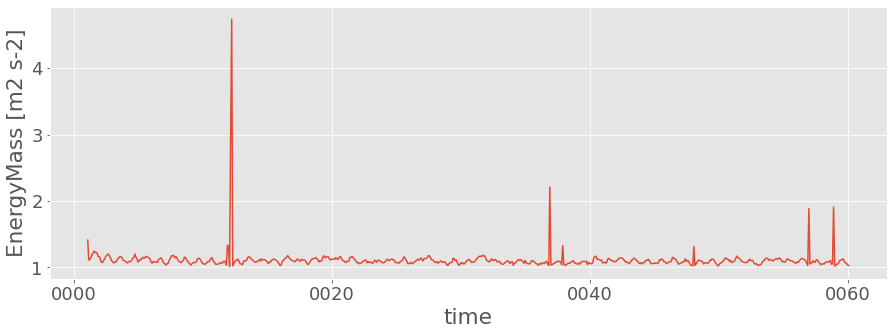

In [27]:
stats_monthly.EnergyMass.plot()

### Mean Sea Level

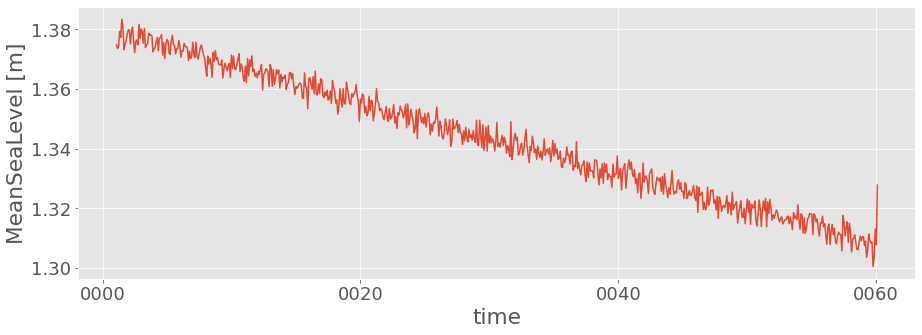

In [28]:
stats_monthly.MeanSeaLevel.plot(); 

### Total Mass

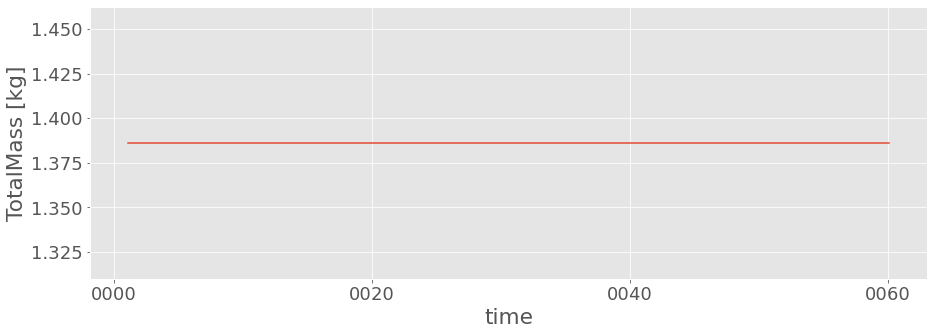

In [29]:
stats_monthly.TotalMass.plot(); 

### Mean Salinity

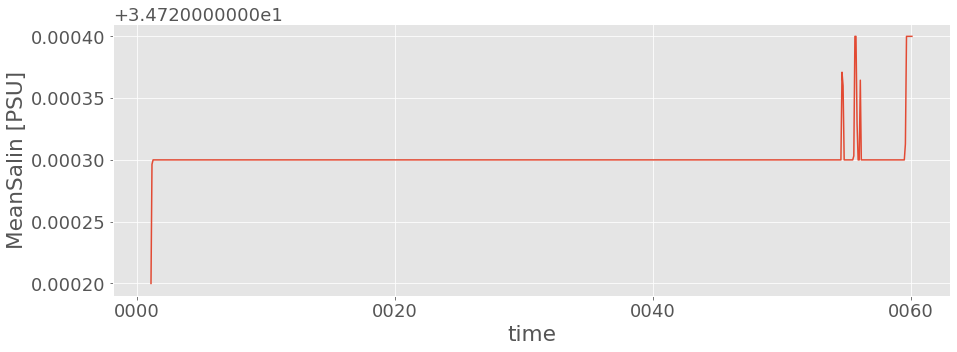

In [30]:
stats_monthly.MeanSalin.plot(); 

### Mean Temperature

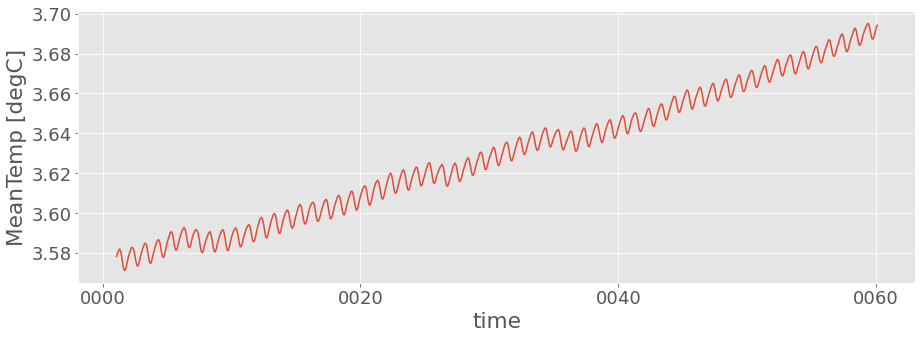

In [31]:
stats_monthly.MeanTemp.plot(); 

### Total Energy

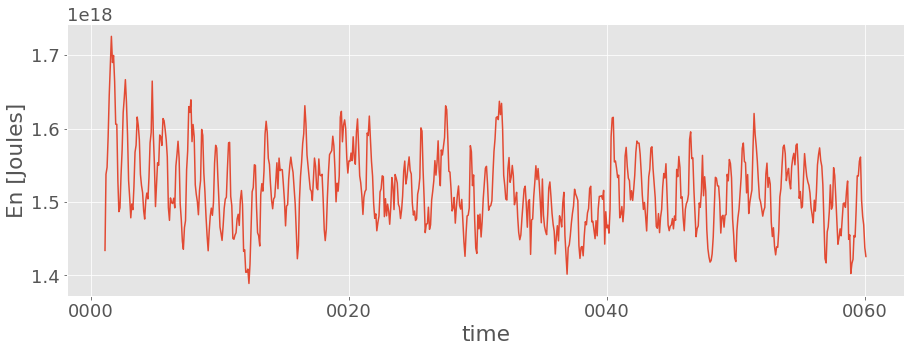

In [32]:
stats_monthly.En.plot(); 

### Available Potential Energy

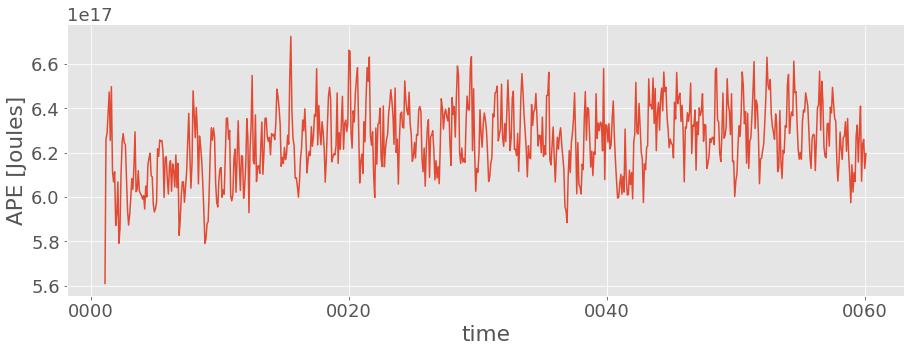

In [33]:
stats_monthly.APE.sum(axis=1,
                      keep_attrs=True).plot(); 

### Total Salt

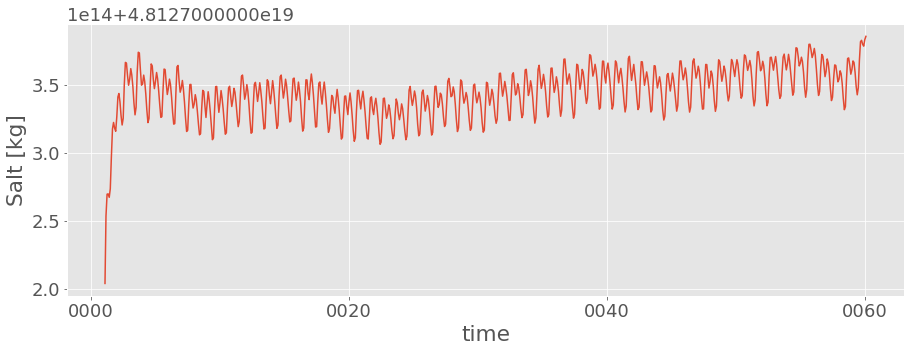

In [34]:
stats_monthly.Salt.plot(); 

### Total Salt Change between Entries

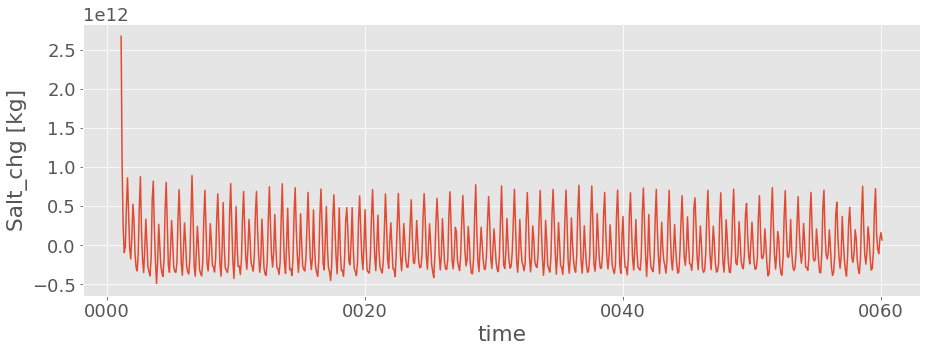

In [35]:
stats_monthly.Salt_chg.plot(); 

### Anomalous Total Salt Change

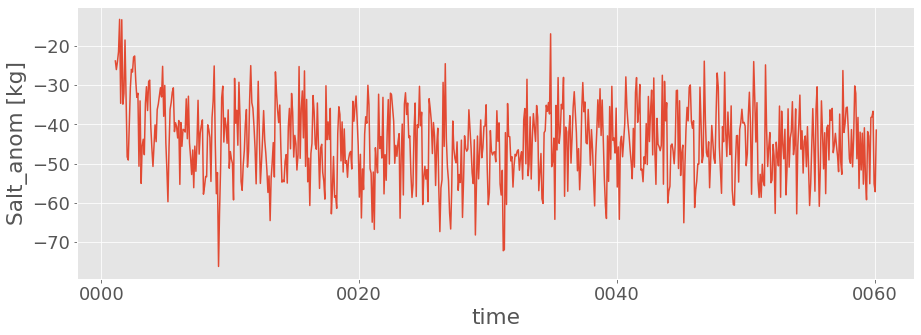

In [36]:
stats_monthly.Salt_anom.plot(); 

### Total Heat

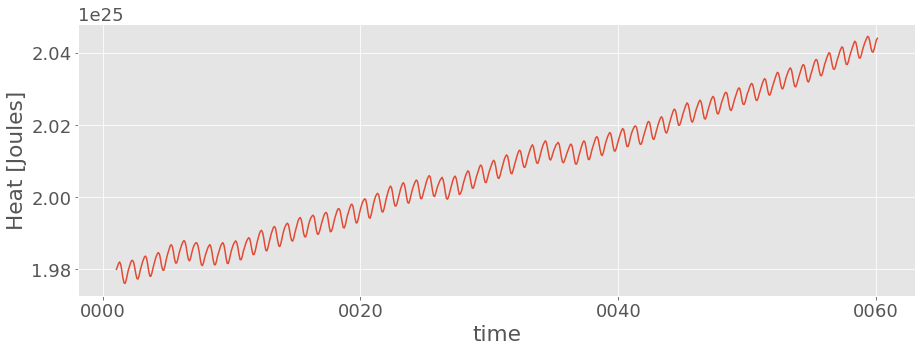

In [37]:
stats_monthly.Heat.plot(); 

### Total Heat Change between Entries

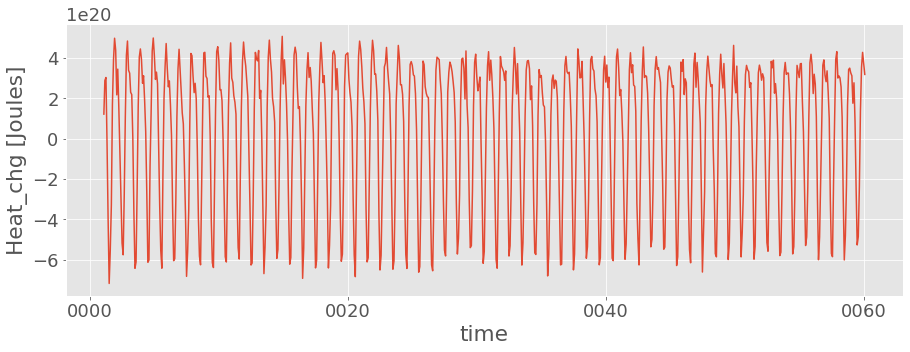

In [38]:
stats_monthly.Heat_chg.plot(); 

### Anomalous Total Heat Change

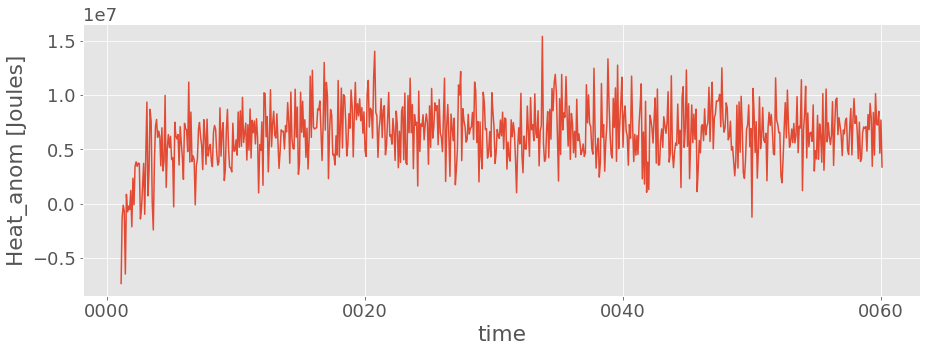

In [39]:
stats_monthly.Heat_anom.plot(); 

### Age

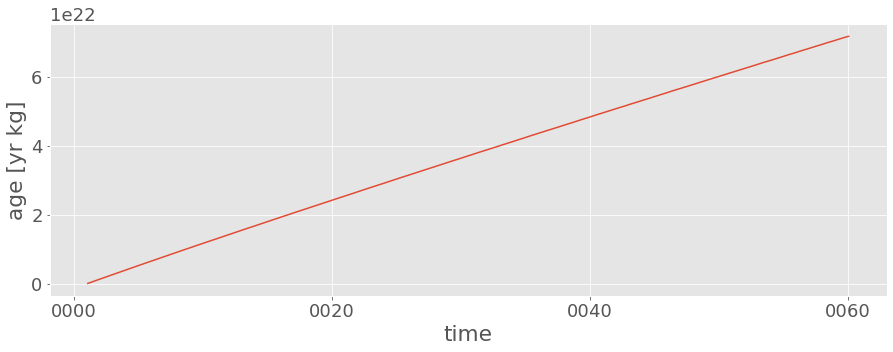

In [40]:
stats_monthly.age.plot(); 